\newpage

# Imports necesarios

In [ ]:
# 1. Para manejar los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Librerías de Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Análisis de los datos

In [2]:
path = "/home/edgar/GitHub/Proyectos/Hackathon_salud/archive/Chronic_Kidney_Dsease_data.csv"
df = pd.read_csv(path)
print(df.head())

   PatientID  Age  Gender  Ethnicity  SocioeconomicStatus  EducationLevel  \
0          1   71       0          0                    0               2   
1          2   34       0          0                    1               3   
2          3   80       1          1                    0               1   
3          4   40       0          2                    0               1   
4          5   43       0          1                    1               2   

         BMI  Smoking  AlcoholConsumption  PhysicalActivity  ...   Itching  \
0  31.069414        1            5.128112          1.676220  ...  7.556302   
1  29.692119        1           18.609552          8.377574  ...  6.836766   
2  37.394822        1           11.882429          9.607401  ...  2.144722   
3  31.329680        0           16.020165          0.408871  ...  7.077188   
4  23.726311        0            7.944146          0.780319  ...  3.553118   

   QualityOfLifeScore  HeavyMetalsExposure  OccupationalExposureChem

In [3]:
Lista_pacientes_negativos = []
Lista_pacientes_positivos = []


df = df.drop(columns=['PatientID', 'DoctorInCharge'])

print(df["Diagnosis"][10])
for i in range (len(df.index)):
    if df["Diagnosis"][i] == 0:
        Lista_pacientes_negativos.append(df.iloc[i,:])
    else:
        Lista_pacientes_positivos.append(df.iloc[i,:])




1


# Separar Datos

In [4]:
# Separar características y etiquetas

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# ==========================================
# 2. DIVISIÓN DE DATOS
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Implemetación de Adasyn


In [5]:


# ==========================================
# 3. APLICAR ADASYN
# ==========================================
try:
    # sampling_strategy='auto' intenta equilibrar al 50/50
    adasyn = ADASYN(random_state=42, sampling_strategy='auto')
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    
    print(f"Balance tras ADASYN en Train: {y_train_res.value_counts().to_dict()}")

except ValueError as e:
    print(f"Error en ADASYN: {e}")
    print("Nota: ADASYN requiere al menos n_neighbors muestras de la clase minoritaria.")
    X_train_res, y_train_res = X_train, y_train

Balance tras ADASYN en Train: {0: 1237, 1: 1219}


# Implementación de Smote

In [6]:
smote = SMOTE(random_state=42, k_neighbors=5)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Train tras SMOTE: {y_train_smote.value_counts().to_dict()}")

Train tras SMOTE: {1: 1219, 0: 1219}


# Implementación de Random Forest (datos de Adasyn)

In [7]:
# ==========================================
# 4. ENTRENAR EL RANDOM FOREST
# ==========================================
print("\nEntrenando Random Forest...")

# Configuración robusta del modelo
rf_model = RandomForestClassifier(
    n_estimators=200,    # Número de árboles (más suele ser mejor, hasta cierto punto)
    max_depth=None,      # Profundidad máxima (None = hasta que aprenda todo)
    min_samples_split=5, # Evita overfitting (no dividir nodos muy pequeños)
    random_state=42,
    n_jobs=-1            
)

rf_model.fit(X_train_res, y_train_res)


Entrenando Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluación Random Forest (Adasyn)


--- REPORTE DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

           0       0.56      0.19      0.28        27
           1       0.93      0.99      0.96       305

    accuracy                           0.92       332
   macro avg       0.74      0.59      0.62       332
weighted avg       0.90      0.92      0.90       332



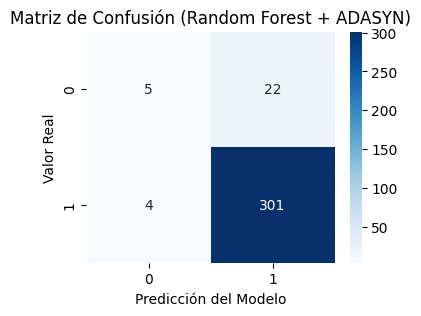


--- TOP 5 VARIABLES MÁS IMPORTANTES ---
GFR                0.095528
SerumCreatinine    0.073752
Itching            0.060924
Gender             0.049101
Diuretics          0.035506
dtype: float64


In [8]:
# Predecimos usando los datos de TEST (que son reales, no sintéticos)
y_pred = rf_model.predict(X_test)

# A) Reporte Numérico
print("\n--- REPORTE DE CLASIFICACIÓN ---")
print(classification_report(y_test, y_pred))

# B) Matriz de Confusión Gráfica
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Random Forest + ADASYN)')

plt.show()

# C) Importancia de Variables (¿Qué columnas pesaron más?)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\n--- TOP 5 VARIABLES MÁS IMPORTANTES ---")
print(feature_importances.nlargest(5))

# Implementación Random Forest (Smote)

In [9]:
# ==========================================
# 4. ENTRENAR EL RANDOM FOREST
# ==========================================
print("\nEntrenando Random Forest...")

# Configuración robusta del modelo
rf_model2 = RandomForestClassifier(
    n_estimators=200,    # Número de árboles (más suele ser mejor, hasta cierto punto)
    max_depth=None,      # Profundidad máxima (None = hasta que aprenda todo)
    min_samples_split=5, # Evita overfitting (no dividir nodos muy pequeños)
    random_state=42,
    n_jobs=-1            
)

rf_model2.fit(X_train_smote, y_train_smote)


Entrenando Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluación random forest (Smote)


--- REPORTE DE CLASIFICACIÓN (SMOTE) ---
              precision    recall  f1-score   support

           0       0.40      0.15      0.22        27
           1       0.93      0.98      0.95       305

    accuracy                           0.91       332
   macro avg       0.66      0.56      0.58       332
weighted avg       0.89      0.91      0.89       332



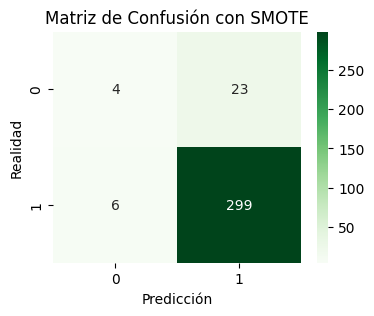


--- TOP 5 VARIABLES MÁS IMPORTANTES ---
GFR                0.106415
SerumCreatinine    0.073079
Itching            0.062118
Gender             0.051841
Diuretics          0.031840
dtype: float64


In [10]:
# ==========================================
# 6. EVALUAR
# ==========================================
y_pred_smote = rf_model2.predict(X_test)

print("\n--- REPORTE DE CLASIFICACIÓN (SMOTE) ---")
print(classification_report(y_test, y_pred_smote))

# Matriz de Confusión
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión con SMOTE')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

# C) Importancia de Variables (¿Qué columnas pesaron más?)
feature_importances = pd.Series(rf_model2.feature_importances_, index=X.columns)
print("\n--- TOP 5 VARIABLES MÁS IMPORTANTES ---")
print(feature_importances.nlargest(5))

# Escalado de datos

In [11]:
scaler = StandardScaler()

X_train_scaled_adasyn = scaler.fit_transform(X_train_res)
X_test_scaled_adasyn = scaler.transform(X_test)

X_train_scaled_smote = scaler.fit_transform(X_train_smote)
X_test_scaled_smote = scaler.transform(X_test)

# Generación y entrenamiento de la Red (Adasyn)

In [ ]:
# ==========================================
# 5. DEFINIR LA ARQUITECTURA DE LA RED NEURONAL
# ==========================================
# Cantidad de columnas de entrada
n_features = X_train_scaled_adasyn.shape[1]

model = Sequential()

# Capa de Entrada + Primera Capa Oculta
# 'units': Cantidad de neuronas (puedes jugar con este número, ej: 32, 64, 128)
# 'activation=relu': La función estándar para capas ocultas
model.add(Dense(units=64, activation='relu', input_shape=(n_features,)))

# Capa de Dropout (Ayuda a evitar overfitting, muy útil con SMOTE)
model.add(Dropout(0.3)) # Apaga el 30% de neuronas al azar en cada paso

# Segunda Capa Oculta
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# Capa de Salida (BINARIA)
# 1 sola neurona porque la respuesta es sí/no.
# 'activation=sigmoid': Fuerza la salida a ser una probabilidad entre 0 y 1.
model.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
# loss='binary_crossentropy': La función de pérdida estándar para clasificación binaria
# metrics: Añadimos Recall y Precision para ver cómo va la clase minoritaria
model.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# ==========================================
# 6. ENTRENAR LA RED (EL PROCESO LENTO)
# ==========================================
print("\n--- Entrenando Red Neuronal ---")
# epochs: Cuántas veces verá el dataset completo
# batch_size: Cuántos datos procesa antes de actualizar sus pesos
# validation_split: Usa una parte del train para validación interna mientras entrena
history = model.fit(
    X_train_scaled_smote, y_train_smote,
    epochs=50,          
    batch_size=32,
    validation_split=0.2, 
    verbose=1 # Pon 0 para que no imprima tanto texto
)


## Evaluación Red Neuronal


--- Evaluando en Test ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0       0.30      0.22      0.26        27
           1       0.93      0.95      0.94       305

    accuracy                           0.89       332
   macro avg       0.62      0.59      0.60       332
weighted avg       0.88      0.89      0.89       332



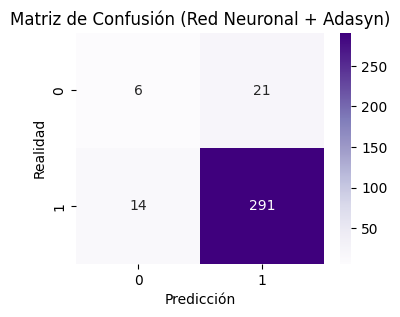

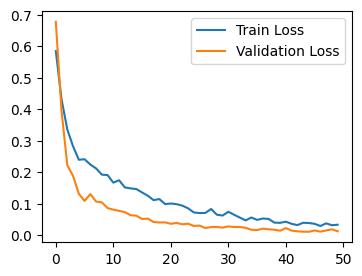

In [13]:

# ==========================================
# 7. EVALUACIÓN
# ==========================================
print("\n--- Evaluando en Test ---")

# Las redes neuronales devuelven probabilidades (ej: 0.89, 0.12)
y_pred_proba = model.predict(X_test_scaled_adasyn)

# Convertimos probabilidades a clases (0 o 1) usando un umbral de 0.5
y_pred_clase = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred_clase))

# Matriz de Confusión
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_clase), annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión (Red Neuronal + Adasyn)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()
plt.figure(figsize=(4, 3))
# (Opcional) Ver la curva de aprendizaje
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.show()

# Construcción y entrenamiento Red (Smote)

In [ ]:
# ==========================================
# 5. DEFINIR LA ARQUITECTURA DE LA RED NEURONAL
# ==========================================
# Cantidad de columnas de entrada
n_features = X_train_scaled_smote.shape[1]

model2 = Sequential()

# Capa de Entrada + Primera Capa Oculta
# 'units': Cantidad de neuronas (puedes jugar con este número, ej: 32, 64, 128)
# 'activation=relu': La función estándar para capas ocultas
model2.add(Dense(units=64, activation='relu', input_shape=(n_features,)))

# Capa de Dropout (Ayuda a evitar overfitting, muy útil con SMOTE)
model2.add(Dropout(0.3)) # Apaga el 30% de neuronas al azar en cada paso

# Segunda Capa Oculta
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.3))

# Capa de Salida (BINARIA)
# 1 sola neurona porque la respuesta es sí/no.
# 'activation=sigmoid': Fuerza la salida a ser una probabilidad entre 0 y 1.
model2.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
# loss='binary_crossentropy': La función de pérdida estándar para clasificación binaria
# metrics: Añadimos Recall y Precision para ver cómo va la clase minoritaria
model2.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# ==========================================
# 6. ENTRENAR LA RED (EL PROCESO LENTO)
# ==========================================
print("\n--- Entrenando Red Neuronal ---")
# epochs: Cuántas veces verá el dataset completo
# batch_size: Cuántos datos procesa antes de actualizar sus pesos
# validation_split: Usa una parte del train para validación interna mientras entrena
history2 = model2.fit(
    X_train_scaled_smote, y_train_smote,
    epochs=50,          
    batch_size=32,
    validation_split=0.2, 
    verbose=1 # Pon 0 para que no imprima tanto texto
)

## Evaluación


--- Evaluando en Test ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.35      0.26      0.30        27
           1       0.94      0.96      0.95       305

    accuracy                           0.90       332
   macro avg       0.64      0.61      0.62       332
weighted avg       0.89      0.90      0.89       332



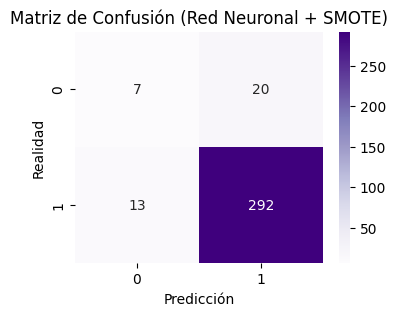

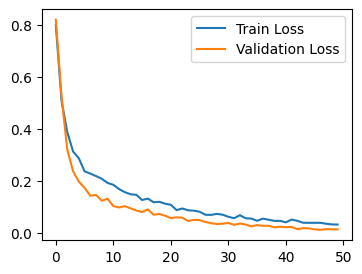

In [15]:
# ==========================================
# 7. EVALUACIÓN
# ==========================================
print("\n--- Evaluando en Test ---")

# Las redes neuronales devuelven probabilidades (ej: 0.89, 0.12)
y_pred_proba = model2.predict(X_test_scaled_smote)

# Convertimos probabilidades a clases (0 o 1) usando un umbral de 0.5
y_pred_clase = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred_clase))

# Matriz de Confusión
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_clase), annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión (Red Neuronal + SMOTE)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()
# (Opcional) Ver la curva de aprendizaje
plt.figure(figsize=(4, 3))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend(); plt.show()